In [94]:
import numpy as np
import os
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import scipy
from scipy import io
from scipy.io import loadmat
import numpy as np
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

In [95]:
categories = ["0", "1", "2", "3", "4", "5", "6","7", "8", "9"]
values = array(categories) #same as above array[]
label_encoder = LabelEncoder()
int_encoded = label_encoder.fit_transform(values) #[0,1,2,3,4,5,6,7,8,9]
onehot_encoder = OneHotEncoder(sparse=True)
int_encoded = int_encoded.reshape(-1,1) #(10,1) matrix 
onehot_encoded = onehot_encoder.fit_transform(int_encoded) 
#print(onehot_encoded)

In [96]:
#Load dataset and segregate labels from images
image_training= io.loadmat('../input/train_32x32.mat')
image_testing= io.loadmat('../input/test_32x32.mat')
train_image= image_training['X']
train_tag= image_training['y']
test_image= image_testing['X']
test_tag= image_testing['y']

In [97]:
print("Training", train_image.shape, train_tag.shape)

Training (32, 32, 3, 73257) (73257, 1)


In [98]:
#univariate Statistical data
print("Train Mean", np.mean(train_image))
print("Test Mean", np.mean(test_image))
print("Train std-Deviation", np.std(train_image))
print("Test std-Deviation", np.std(test_image))

Train Mean 115.11177966923525
Test Mean 116.78117117073857
Train std-Deviation 50.81926790623289
Test std-Deviation 57.37636659640377


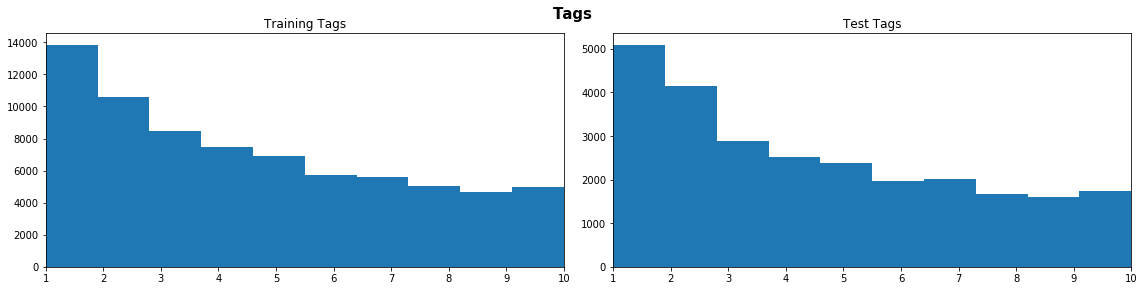

In [99]:
#Plot distribution of tags in training and test

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
fig.suptitle('Tags', fontsize=15, fontweight='bold', y=1)

ax1.hist(train_tag, bins=10)
ax1.set_title("Training Tags")
ax1.set_xlim(1, 10)

ax2.hist(test_tag, bins=10);
ax2.set_title("Test Tags");

fig.tight_layout()

In [100]:
#required format
train_image = np.transpose(train_image, (3, 0, 1, 2))
test_image = np.transpose(test_image, (3, 0, 1, 2))
train_tag = train_tag[:,0]
test_tag= test_tag[:,0]
print("Training", train_image.shape, train_tag.shape)

Training (73257, 32, 32, 3) (73257,)


In [101]:
#check the tags available
print(np.unique(train_tag))

[ 1  2  3  4  5  6  7  8  9 10]


In [102]:
#change tag 10 to 0
train_tag[train_tag == 10] = 0
test_tag[test_tag == 10] = 0
print(np.unique(train_tag))

[0 1 2 3 4 5 6 7 8 9]


In [103]:
#Function for plotting
def plot_images(image, nrows, ncols, tags):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if image[i].shape == (32, 32, 3):
            ax.imshow(image[i])
        else:
            ax.imshow(image[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(tags[i])

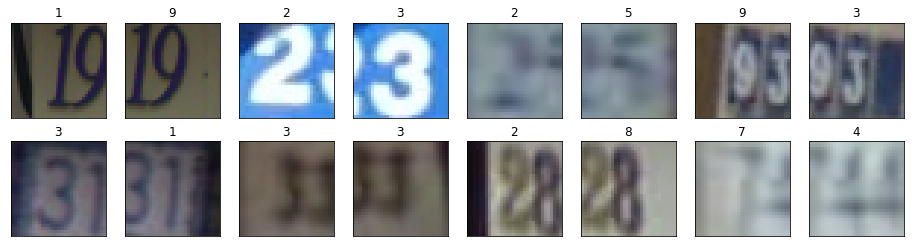

In [104]:
plot_images(train_image, 2, 8, train_tag)

In [105]:
print(train_image.shape, train_tag.shape)
print(test_image.shape, test_tag.shape)

(73257, 32, 32, 3) (73257,)
(26032, 32, 32, 3) (26032,)


In [106]:
from sklearn.model_selection import train_test_split

test_image,crossvalidation_image,test_tag,crossvalidation_tag= train_test_split(test_image,test_tag,test_size=13016,random_state=106)

In [107]:
print ('Train data:', train_image.shape,', Train Tag:', train_tag.shape)
print ('Test data:', test_image.shape,', Test Tag:', test_tag.shape)
print ('Crossvalidation data:', crossvalidation_image.shape,', Crossvalidation tag:', crossvalidation_tag.shape)

Train data: (73257, 32, 32, 3) , Train Tag: (73257,)
Test data: (13016, 32, 32, 3) , Test Tag: (13016,)
Crossvalidation data: (13016, 32, 32, 3) , Crossvalidation tag: (13016,)


In [108]:
from sklearn.preprocessing import OneHotEncoder
 
# Fit the OneHotEncoder
enc = OneHotEncoder().fit(train_tag.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
train_tag = enc.transform(train_tag.reshape(-1, 1)).toarray()
test_tag = enc.transform(test_tag.reshape(-1, 1)).toarray()
crossvalidation_tag = enc.transform(crossvalidation_tag.reshape(-1, 1)).toarray()

print("Training set", train_tag.shape)
print("Test set", test_tag.shape)
print("Training set", crossvalidation_tag.shape)

Training set (73257, 10)
Test set (13016, 10)
Training set (13016, 10)


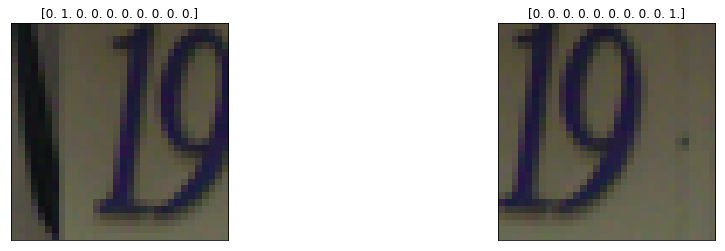

In [109]:
plot_images(train_image, 1, 2, train_tag)

In [110]:
def rgb2gray(images):
    greyconvert = np.dot(images, [0.299, 0.587, 0.114]) #reference: https://angeljohnsy.blogspot.com/2011/04/rgb-image-to-grayscale-image.html
    return np.expand_dims(greyconvert, axis=3)

train_greyscale = rgb2gray(train_image).astype(np.float32)
test_greyscale = rgb2gray(test_image).astype(np.float32)
crossvalidation_greyscale = rgb2gray(crossvalidation_image).astype(np.float32)

In [111]:
import tensorflow as tf
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import keras
import tempfile
import pandas as pd

num_classes = 10
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(4,4),activation='relu',input_shape=(32, 32, 1)))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(32, kernel_size = (4,4), activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(32, kernel_size = (4,4), activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(num_classes, activation='softmax'))
    
cnn.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

history_cnn = cnn.fit(train_greyscale, train_tag,batch_size=128, epochs=5, verbose=1, validation_split=.1)
scores = cnn.evaluate(crossvalidation_greyscale, crossvalidation_tag, batch_size = 128, verbose = 0)
print("%s: %.2f%%" % (cnn.metrics_names[1], scores[1]*100))

Train on 65931 samples, validate on 7326 samples
Epoch 1/5
65931/65931 [==============================] - 598s 9ms/step - loss: 0.7454 - acc: 0.7666 - val_loss: 0.4914 - val_acc: 0.8534
Epoch 2/5
65931/65931 [==============================] - 591s 9ms/step - loss: 0.3799 - acc: 0.8850 - val_loss: 0.3552 - val_acc: 0.8938
Epoch 3/5
65931/65931 [==============================] - 592s 9ms/step - loss: 0.3012 - acc: 0.9093 - val_loss: 1.2575 - val_acc: 0.7285
Epoch 4/5
65931/65931 [==============================] - 593s 9ms/step - loss: 0.2657 - acc: 0.9196 - val_loss: 0.3461 - val_acc: 0.9024
Epoch 5/5
65931/65931 [==============================] - 578s 9ms/step - loss: 0.2120 - acc: 0.9351 - val_loss: 0.3848 - val_acc: 0.8898
acc: 87.65%


In [112]:
num_classes = 10
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(4,4),activation='relu',input_shape=(32, 32, 1)))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(32, kernel_size = (4,4), activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(32, kernel_size = (4,4), activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dense(num_classes, activation='softmax'))
    
cnn.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

history_cnn = cnn.fit(train_greyscale, train_tag,batch_size=128, epochs=5, verbose=1, validation_split=.1)
scores = cnn.evaluate(test_greyscale, test_tag, batch_size = 128, verbose = 0)
print("%s: %.2f%%" % (cnn.metrics_names[1], scores[1]*100))

Train on 65931 samples, validate on 7326 samples
Epoch 1/5
65931/65931 [==============================] - 595s 9ms/step - loss: 0.7980 - acc: 0.7471 - val_loss: 0.4647 - val_acc: 0.8601
Epoch 2/5
65931/65931 [==============================] - 591s 9ms/step - loss: 0.3930 - acc: 0.8803 - val_loss: 0.5304 - val_acc: 0.8400
Epoch 3/5
65931/65931 [==============================] - 595s 9ms/step - loss: 0.3107 - acc: 0.9052 - val_loss: 0.3491 - val_acc: 0.8950
Epoch 4/5
65931/65931 [==============================] - 594s 9ms/step - loss: 0.2567 - acc: 0.9216 - val_loss: 0.4179 - val_acc: 0.8802
Epoch 5/5
65931/65931 [==============================] - 601s 9ms/step - loss: 0.2206 - acc: 0.9323 - val_loss: 0.3280 - val_acc: 0.9064
acc: 88.91%
